<a href="https://colab.research.google.com/github/Rogerio-mack/work/blob/main/Concatenate_tabular_and_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integrando Imagens e Dados Tabulares para no treinamento de uma Rede Neural**

A ideia desse tipo de modelo é enriquecer dados de imagens (por exemplo, imagens de possíveis tumores ou um aneurisma) com metadados (dados tabulares dos pacientes, como idade e sexo) que podem ter influência na tarefa do modelo (classificação ou regressão. Do mesmo modo, pode ser aplicado para enriquecer dados tabulares (como dados de imóveis como metros quadrados, localização etc.) com iamgens dos imóveis para, por exemplo, uma tarefa de estimativa do preço dos imóveis.



# Abordagem Geral

A solução para integração desses dados consiste em criarmos dois ramos da rede para o aprendizado. Um ramo para a imagem (em geral um rede convolucional) e um ramo para os dados tabulares que são, em seguida, concatenados para produzir a saída da rede.

A solução pode incluir a construção completa ou ainda empregar modelos, em especial para as imagens, o treinamento (*fine-tunning*) de modelos pré-treinados como o VGG16, VGG19, ResNet50 etc.

![imagem](https://github.com/Rogerio-mack/work/blob/main/integrando_imagens_dados_tabulares.png?raw=true)

<small>
Fonte: https://towardsdatascience.com/integrating-image-and-tabular-data-for-deep-learning-9281397c7318



# Exemplo de *Brinquedo*



Apenas para ilustrar esse mecanismo, construímos nesse exemplo de *brinquedo* (*toy-example*) dois modelos, um do treinamento de uma rede neural completa (do zero) e outro empregando um modelo pré-treinado de imagens (VGG16), para a classificação das imagens de dígitos do MNIST criando valores fictícios para os dados tabulares, como uma função linear ($2x + 1$) e quadrada {$x^2 + 4$) do dígito da imagem acrescida de uma parcela randomizada.

Aqui os modelos executam uma tarefa de classificação, mas a mesma estrutura pode ser empregada para tarefas de regressão.




![imagem](https://github.com/Rogerio-mack/work/blob/main/integrando_imagens_dados_tabulares2.png?raw=true)



# Treinamento de uma rede neural completa

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [64]:
# Carregar dados MNIST para exemplo de imagens
(x_train_img, y_train), (x_test_img, y_test) = mnist.load_data()

# Redimensionar as imagens para (28, 28, 1)
x_train_img = x_train_img.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_img = x_test_img.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Gerar dados tabulares fictícios
num_samples = x_train_img.shape[0]
x_train_tabular = np.concatenate((2 * y_train.reshape(-1,1) + 1, y_train.reshape(-1,1)**2 + 4),axis=1)
x_train_tabular = x_train_tabular + \
np.concatenate((np.random.normal(0, 0.1, size=x_train_tabular.shape[0]),np.random.normal(0, 0.1, size=x_train_tabular.shape[0])),axis=0).reshape(x_train_tabular.shape[0],2)

x_test_tabular = np.concatenate((2 * y_test.reshape(-1,1) + 1, y_test.reshape(-1,1)**2 + 4),axis=1)
x_test_tabular = x_test_tabular + \
np.concatenate((np.random.normal(0, 0.1, size=x_test_tabular.shape[0]),np.random.normal(0, 0.1, size=x_test_tabular.shape[0])),axis=0).reshape(x_test_tabular.shape[0],2)

# x_train_tabular = np.random.rand(num_samples, 10)
# x_test_tabular = np.random.rand(x_test_img.shape[0], 10)

# Convertendo os rótulos para one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Construir o ramo para dados tabulares
input_tabular = Input(shape=(2,), name='tabular_input')
# input_tabular = Input(shape=(2,), name='tabular_input')
x_tabular = Dense(32, activation='relu')(input_tabular)
x_tabular = Dense(32, activation='relu')(x_tabular)

# Construir o ramo para dados de imagem
input_image = Input(shape=(28, 28, 1), name='image_input')
x_image = Flatten()(input_image)
x_image = Dense(128, activation='relu')(x_image)
x_image = Dense(64, activation='relu')(x_image)

# Concatenar os ramos
concatenated = Concatenate()([x_tabular, x_image])
output = Dense(10, activation='softmax')(concatenated)

# Construir o modelo
model = Model(inputs=[input_tabular, input_image], outputs=output)

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
model.summary()

# Treinar o modelo
model.fit([x_train_tabular, x_train_img], y_train, epochs=5, batch_size=32, validation_split=0.2)

# Avaliar o modelo
test_loss, test_acc = model.evaluate([x_test_tabular, x_test_img], y_test)
print('Test accuracy:', test_acc)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 tabular_input (InputLayer)  [(None, 2)]                  0         []                            
                                                                                                  
 flatten_4 (Flatten)         (None, 784)                  0         ['image_input[0][0]']         
                                                                                                  
 dense_20 (Dense)            (None, 32)                   96        ['tabular_input[0][0]']       
                                                                                            

1/1 [==============================] - 0s 88ms/step


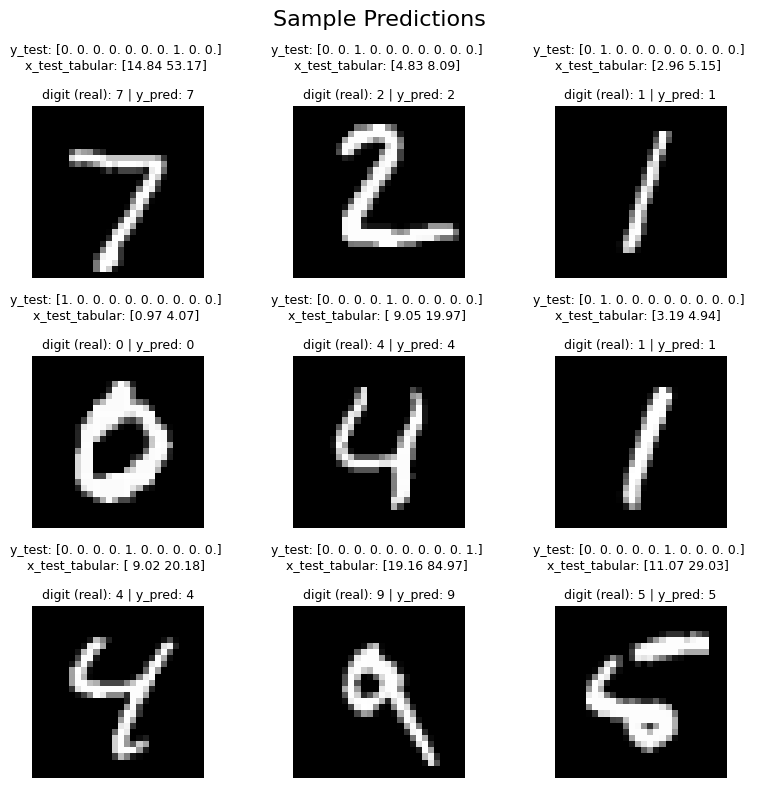

In [65]:
import matplotlib.pyplot as plt

# Selecionar as primeiras 9 imagens
x_test_images = x_test_img[:9]
y_test_labels = y_test[:9]
x_test_tabular_data = x_test_tabular[:9]

y_pred = model.predict([x_test_tabular[:9], x_test_img[:9]]).argmax(axis=1)

# Configurar o layout do gráfico
plt.figure(figsize=(8, 8))

# Loop para exibir as imagens e os valores
for i in range(9):
    # Subplot para a imagem
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Título com os valores
    plt.title(f"y_test: {y_test_labels[i]} \nx_test_tabular: {x_test_tabular_data[i].round(2)} \n\ndigit (real): {y_test_labels[i].argmax()} | y_pred: {y_pred[i]}", fontsize=9)

# Exibir o gráfico
plt.suptitle('Sample Predictions', fontsize=16)
plt.tight_layout()
plt.show()


# Treinamento (*Fine-Tunning*) do modelo pré-Treinado `VGG16`

<br>
<br>

<small>
Atenção: mesmo com dados bastante reduzidos (200 instâncias) o tempo de execução do treinamento do modelo pré-treinado pode levar vários minutos (~10-15min, sem uso de GPU).

In [66]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

# Carregar dados MNIST para exemplo de imagens
(x_train_img, y_train), (x_test_img, y_test) = mnist.load_data()

# Reduzir o número de imagens
x_train_img = x_train_img[:200]
y_train = y_train[:200]

x_test_img = x_test_img[:60]
y_test = y_test[:60]

# Redimensionar as imagens para (28, 28, 1)
x_train_img = np.expand_dims(x_train_img, axis=-1)  # adicionar o canal
x_test_img = np.expand_dims(x_test_img, axis=-1)    # adicionar o canal

# Função para converter e redimensionar as imagens
def preprocess_images(images):
    images = tf.image.resize_with_pad(images, 224, 224)  # redimensionar para 224x224
    images = tf.image.grayscale_to_rgb(images)  # converter para 3 canais
    return images

# Aplicar a função de pré-processamento
x_train_img = preprocess_images(x_train_img)
x_test_img = preprocess_images(x_test_img)

# Normalizar os valores dos pixels
x_train_img = x_train_img / 255.0
x_test_img = x_test_img / 255.0

# Gerar novos dados tabulares
x_train_tabular = np.concatenate((2 * y_train.reshape(-1,1) + 1, y_train.reshape(-1,1)**2 + 4),axis=1)
x_train_tabular = x_train_tabular + \
np.concatenate((np.random.normal(0, 0.1, size=x_train_tabular.shape[0]),np.random.normal(0, 0.1, size=x_train_tabular.shape[0])),axis=0).reshape(x_train_tabular.shape[0],2)

x_test_tabular = np.concatenate((2 * y_test.reshape(-1,1) + 1, y_test.reshape(-1,1)**2 + 4),axis=1)
x_test_tabular = x_test_tabular + \
np.concatenate((np.random.normal(0, 0.1, size=x_test_tabular.shape[0]),np.random.normal(0, 0.1, size=x_test_tabular.shape[0])),axis=0).reshape(x_test_tabular.shape[0],2)

# Convertendo os rótulos para one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Construir o ramo para dados tabulares
input_tabular = Input(shape=(2,), name='tabular_input')
x_tabular = Dense(32, activation='relu')(input_tabular)
x_tabular = Dense(32, activation='relu')(x_tabular)

# Construir o ramo para dados de imagem usando VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congela as camadas da VGG16

input_image = Input(shape=(224, 224, 3), name='image_input')
x_image = base_model(input_image, training=False)
x_image = Flatten()(x_image)
x_image = Dense(128, activation='relu')(x_image)
x_image = Dense(64, activation='relu')(x_image)

# Concatenar os ramos
concatenated = Concatenate()([x_tabular, x_image])
output = Dense(10, activation='softmax')(concatenated)

# Construir o modelo
model = Model(inputs=[input_tabular, input_image], outputs=output)

# Compilar o modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
model.summary()

# Treinar o modelo
model.fit([x_train_tabular, x_train_img], y_train, epochs=5, batch_size=32, validation_split=0.2)

# Avaliar o modelo
test_loss, test_acc = model.evaluate([x_test_tabular, x_test_img], y_test)
print('Test accuracy:', test_acc)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['image_input[0][0]']         
                                                          8                                       
                                                                                                  
 tabular_input (InputLayer)  [(None, 2)]                  0         []                            
                                                                                                  
 flatten_5 (Flatten)         (None, 25088)                0         ['vgg16[0][0]']         

1/1 [==============================] - 6s 6s/step


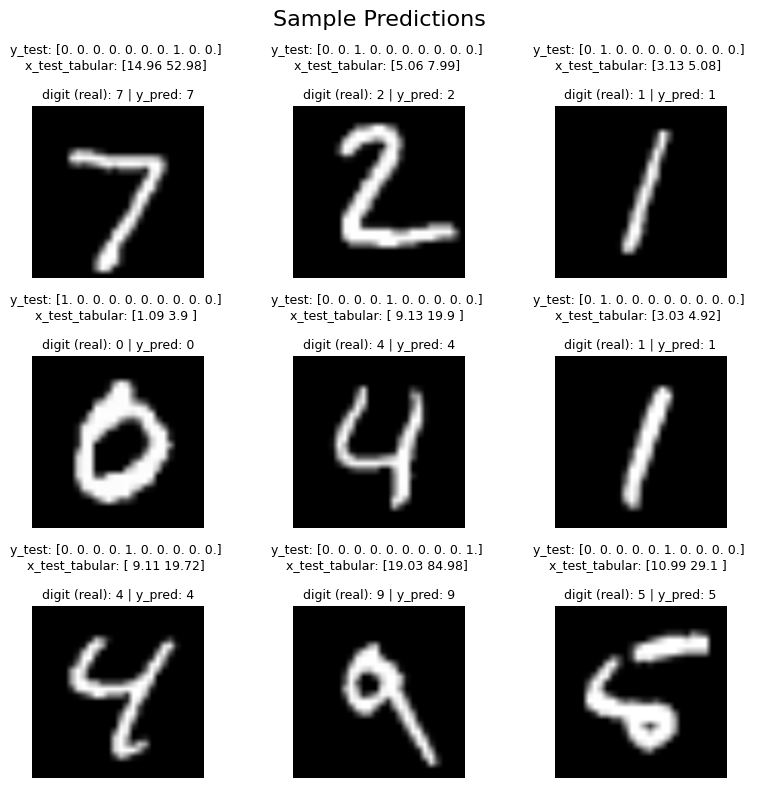

In [68]:
import matplotlib.pyplot as plt

# Selecionar as primeiras 9 imagens
x_test_images = x_test_img[:9]
y_test_labels = y_test[:9]
x_test_tabular_data = x_test_tabular[:9]

y_pred = model.predict([x_test_tabular[:9], x_test_img[:9]]).argmax(axis=1)

# Configurar o layout do gráfico
plt.figure(figsize=(8, 8))

# Loop para exibir as imagens e os valores
for i in range(9):
    # Subplot para a imagem
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(x_test_images[i][:,:,0]).reshape(224, 224), cmap='gray')
    plt.axis('off')

    # Título com os valores
    plt.title(f"y_test: {y_test_labels[i]} \nx_test_tabular: {x_test_tabular_data[i].round(2)} \n\ndigit (real): {y_test_labels[i].argmax()} | y_pred: {y_pred[i]}", fontsize=9)

# Exibir o gráfico
plt.suptitle('Sample Predictions', fontsize=16)
plt.tight_layout()
plt.show()